In [ ]:
import torch
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset
from directed_graphs.datasets import affinity_grid_search
from directed_graphs.datasets import visualize_heatmap
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")

## Import RNA Velocity Data

In [ ]:
import scvelo as scv
import numpy as np
scv.set_figure_params()
adata = scv.datasets.pancreas()

In [ ]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
scv.tl.velocity(adata, mode='stochastic',n_jobs=10)

computing velocities
    finished (0:00:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [ ]:
scv.tl.velocity_graph(adata,n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


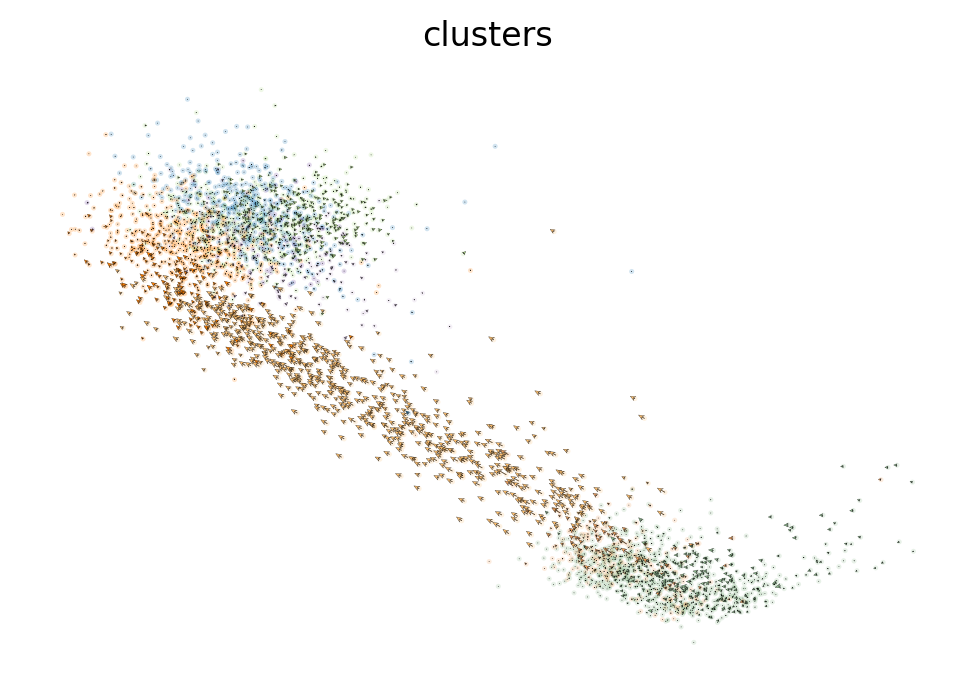

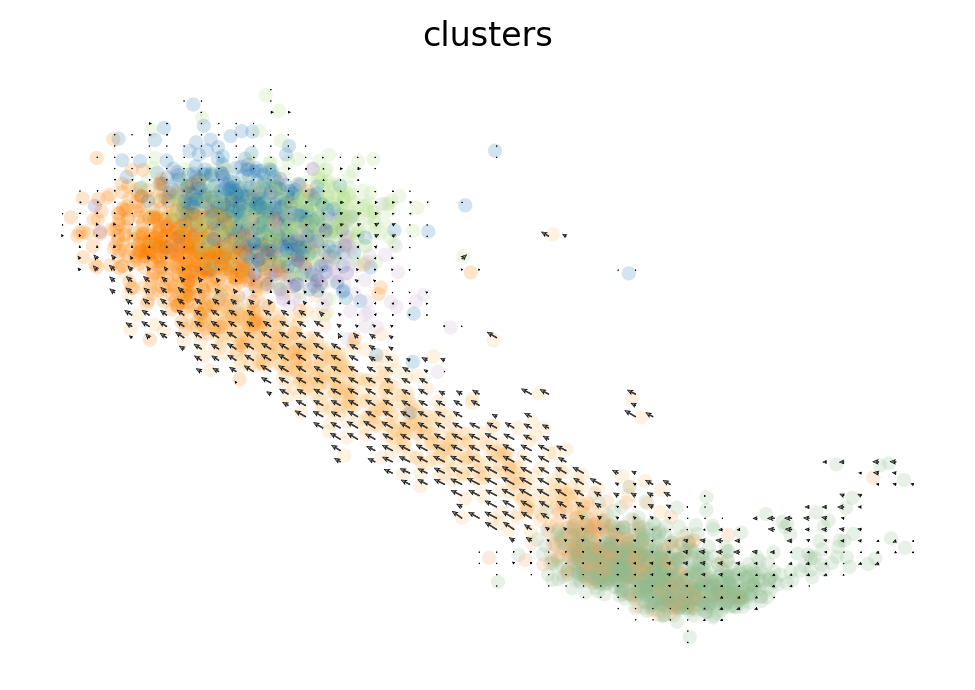

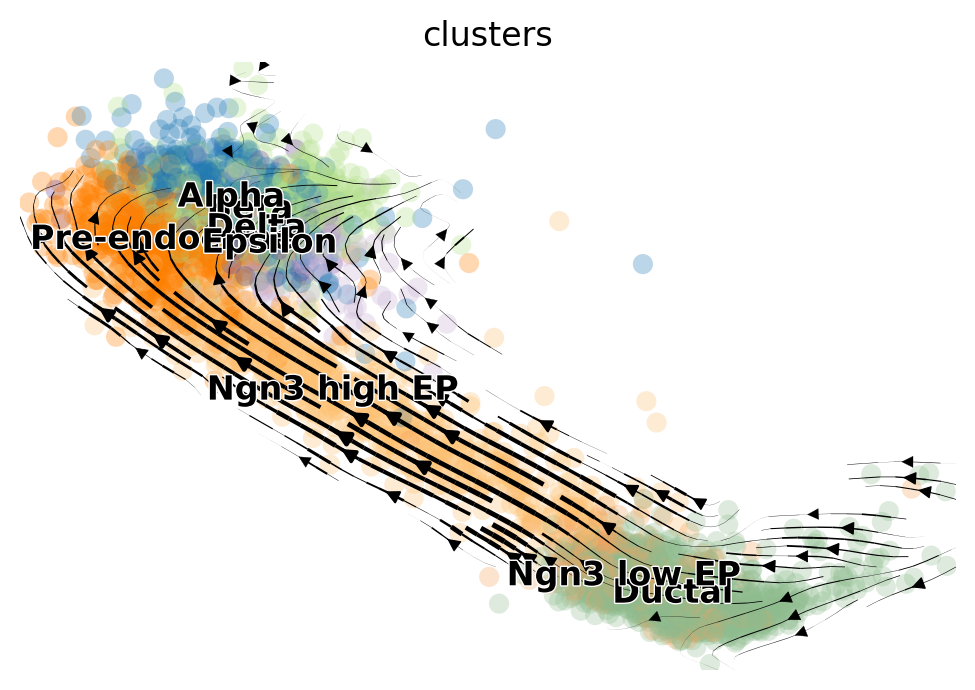

In [ ]:
scv.pl.velocity_embedding(adata, basis='pca')
scv.pl.velocity_embedding_grid(adata, basis='pca')
scv.pl.velocity_embedding_stream(adata, basis='pca')

In [ ]:
import scipy
X = scipy.sparse.csr_matrix.todense(adata.X)
X = torch.tensor(X)
X = torch.tensor(adata.obsm["X_pca"])
flow = torch.tensor(adata.obsm["velocity_pca"])

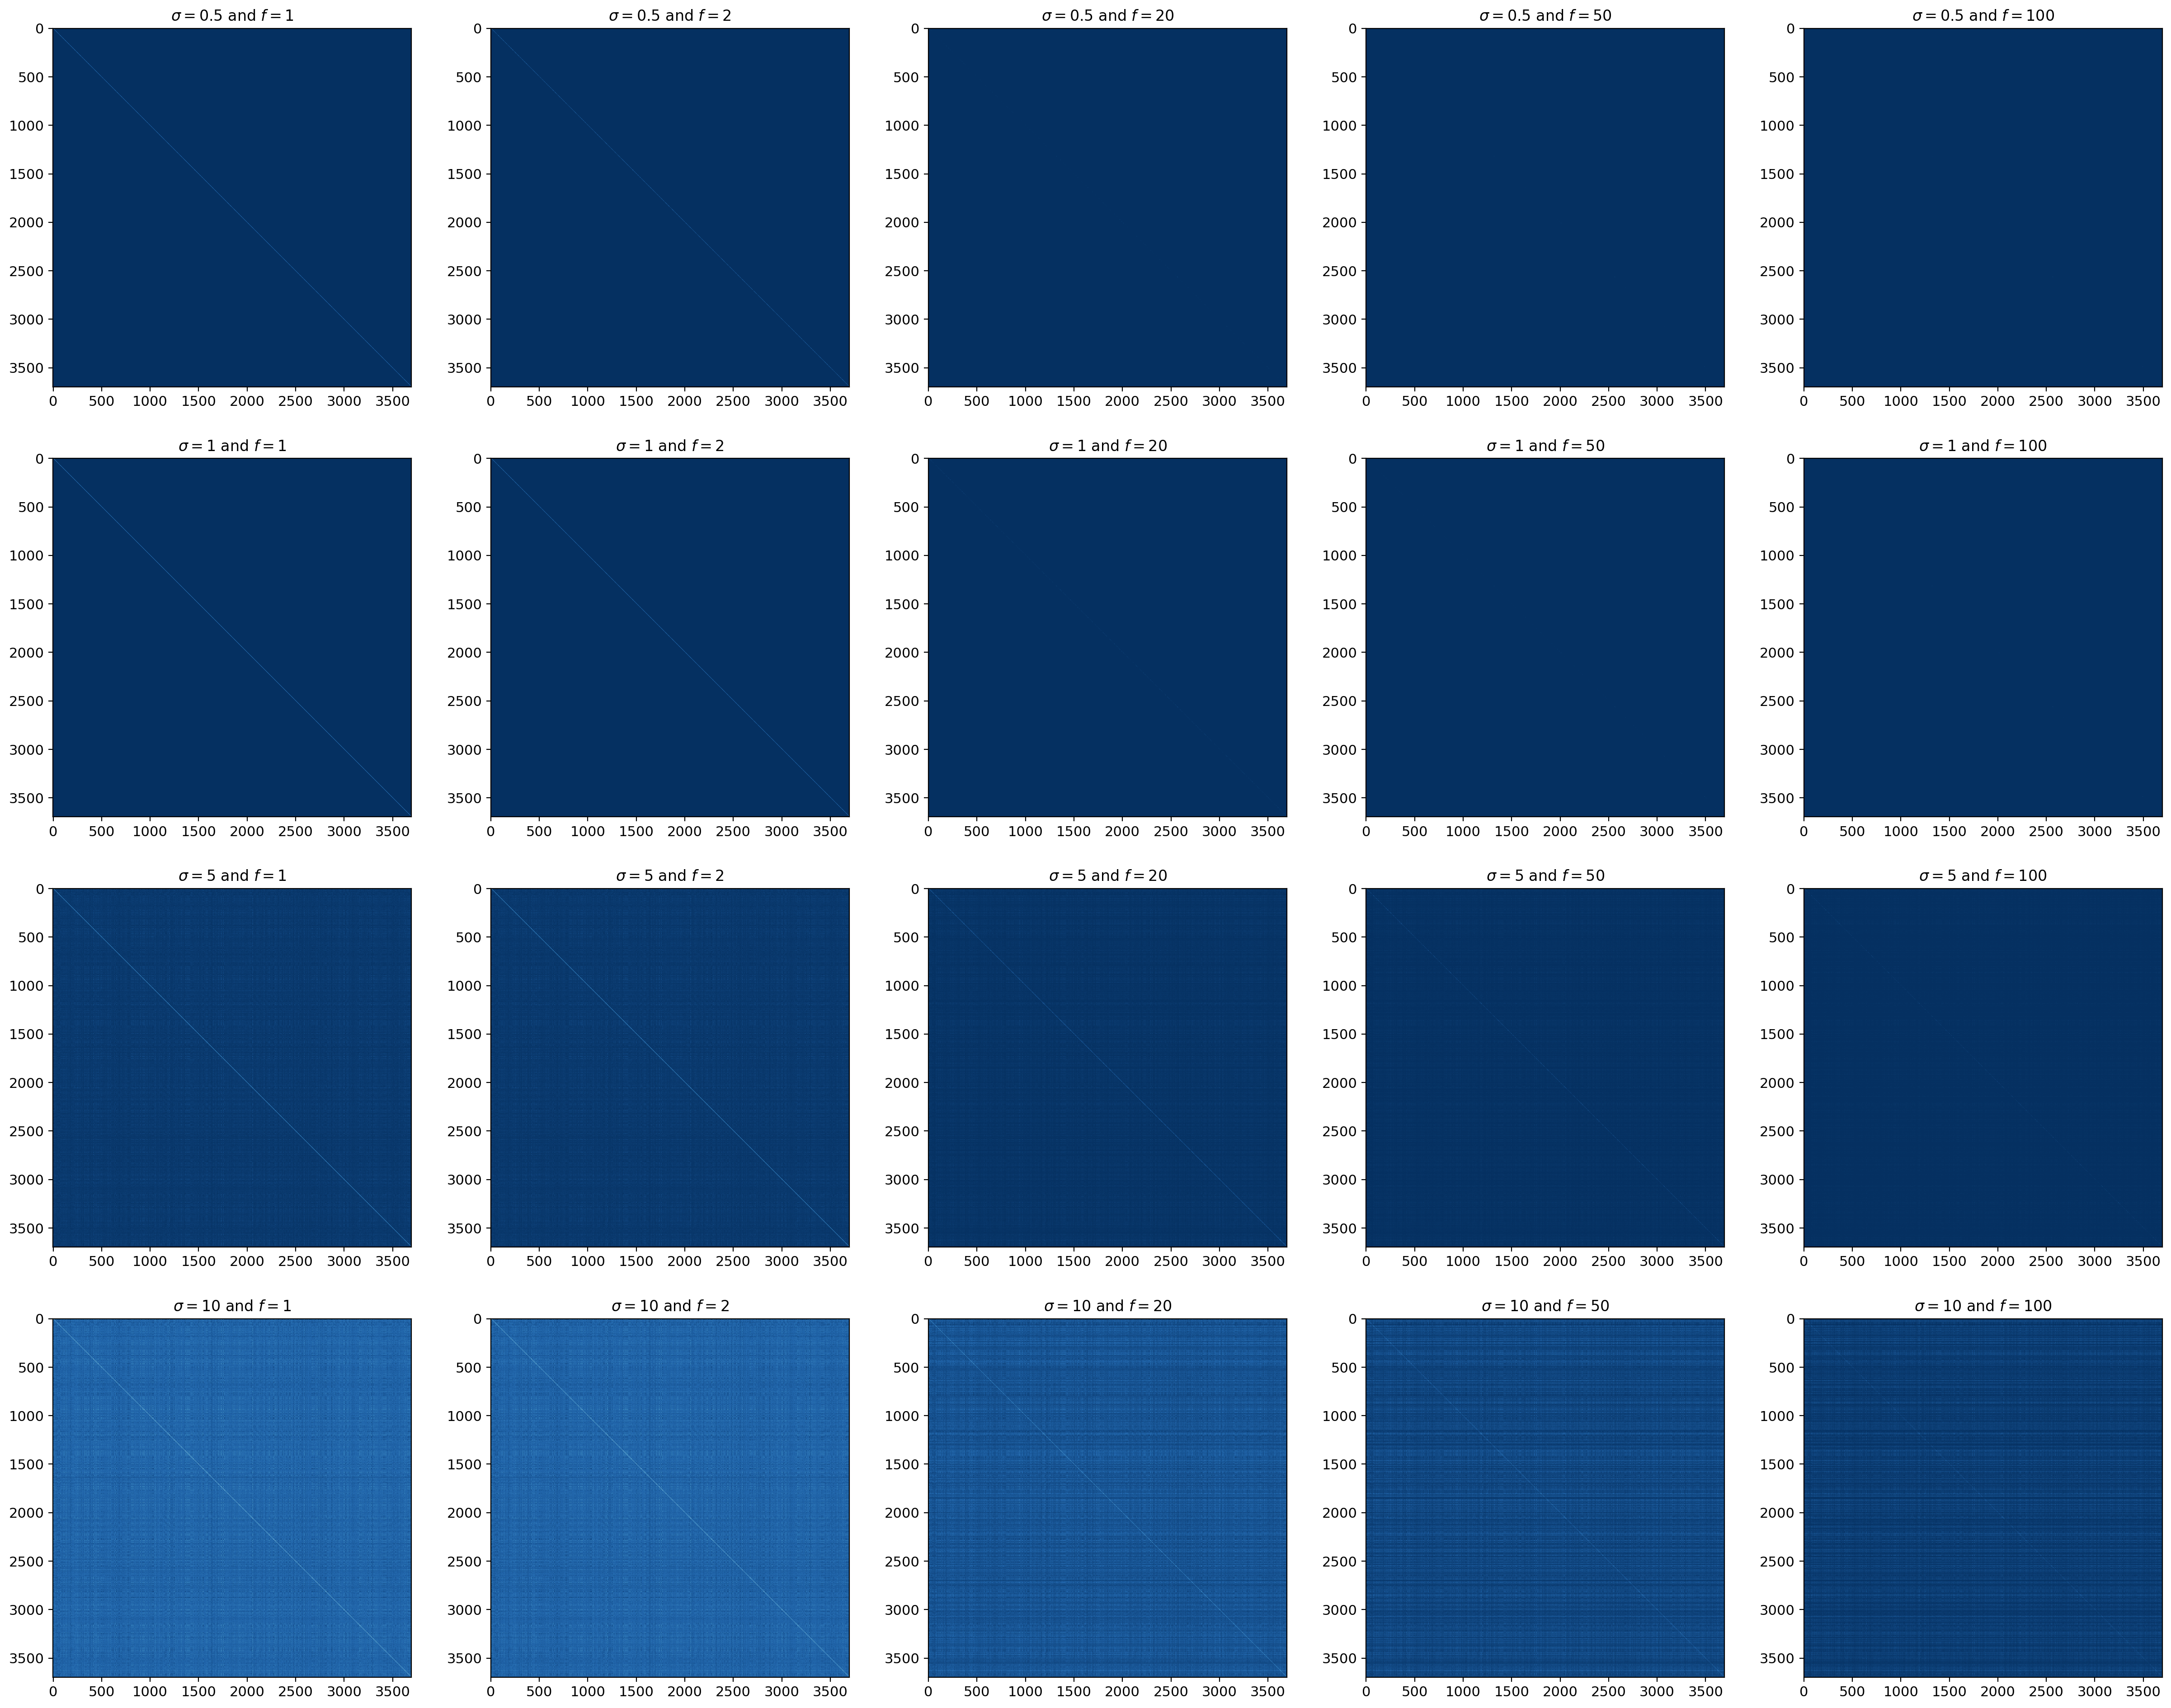

In [ ]:
sigmas = [0.5, 1, 5, 10]
flow_strengths = [1, 2, 20, 50,100]
affinity_grid_search(X, flow, sigmas, flow_strengths)

## UW Algorithm

In [ ]:
def UW_directed_embedding(W, m):
    # steps 1-6 (estimate coordinates according to diffusion map)
    # step 1
    S = (W + np.transpose(W))/2 # symmetric affinity matrix

    # step 2
    q = np.sum(S, axis = 1)
    Q = np.diag(q) # degree matrix

    # step 3
    Qinv = np.linalg.inv(Q)
    V = Qinv@S@Qinv # anisotropic normalized affinity matrix

    # step 4
    q1 = np.sum(V, axis=1)
    Q1 = np.diag(q) # normalized degree matrix
    Q1inv = np.linalg.inv(Q1) # 
    
    # step 5
    Hss = Q1inv@V # diffusion matrix (dividing affinity matrix by row sums)

    # step 6
    eig_vals, eig_vecs = np.linalg.eig(Hss)
    idx = eig_vals.argsort()[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]

    phi = eig_vecs[:,:(m+1)] # first (m+1) right eigenvectors
    coords = eig_vecs[:,1:(m+1)] # first m significant right eigenvectors (coordinates of points in embedding)
    A = np.diag(eig_vals) # diagonal matrix of (m+1) significant eigenvalues


    # step 7-8: estimate the density
    density = 0.1
    """
    evals, evecs = scipy.linalg.eig(Hss, left = True, right = False)
    pi = evecs[np.where(evals == 1)] # left eigenvector of Hss with eigenvalue 1
    density = pi/sum(pi) # normalize
    """

    # step 9-13: estimate vector field r
    # step 9
    p = np.sum(W, axis = 1)
    P = np.diag(p)

    # step 10
    Pinv = np.linalg.inv(P)
    T = Pinv@W@Pinv
    p1 = np.sum(T, axis = 1)
    P1 = np.diag(p1)

    # step 11
    P1inv = np.linalg.inv(P1)
    Haa = P1@T

    R = ((Haa - Hss)@phi)
    fields = R[:,1:] # vector field components in the direction of the corresponding coordinates of the embedding

    return coords, density, fields

In [ ]:
def visualize_UW_dir_emb(coords, density, fields):

    x = [a[0] for a in coords]
    y = [a[1] for a in coords]
    plt.scatter(x, y)
    plt.quiver(x, y, fields[:,0], fields[:,1])

In [ ]:
A = np.asarray(A)
coords, density, fields = UW_directed_embedding(A, 2)

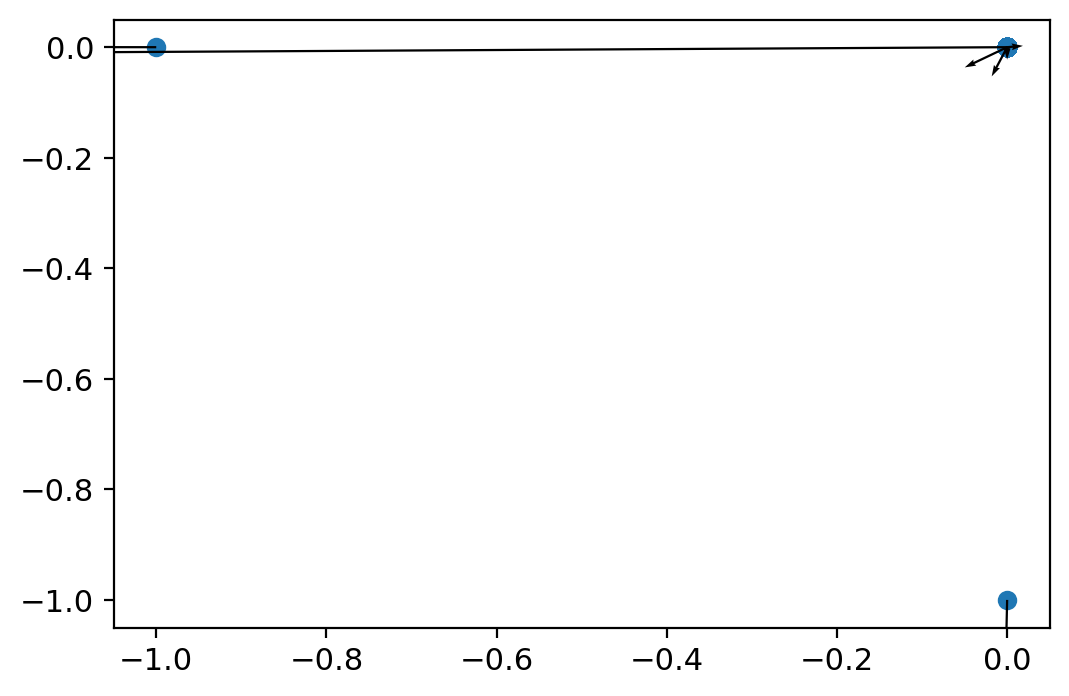

In [ ]:
import matplotlib.pyplot as plt

visualize_UW_dir_emb(coords, density, fields)

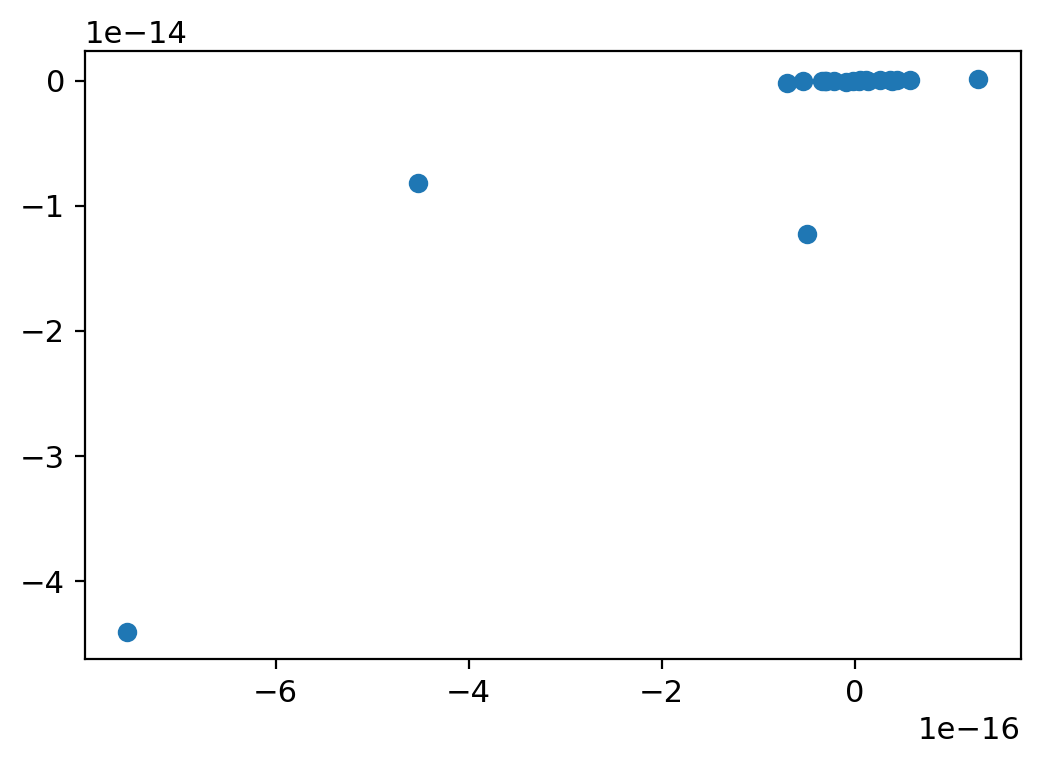

In [ ]:
c1 = coords[:21]

x = [a[0] for a in c1]
y = [a[1] for a in c1]
plt.scatter(x, y)

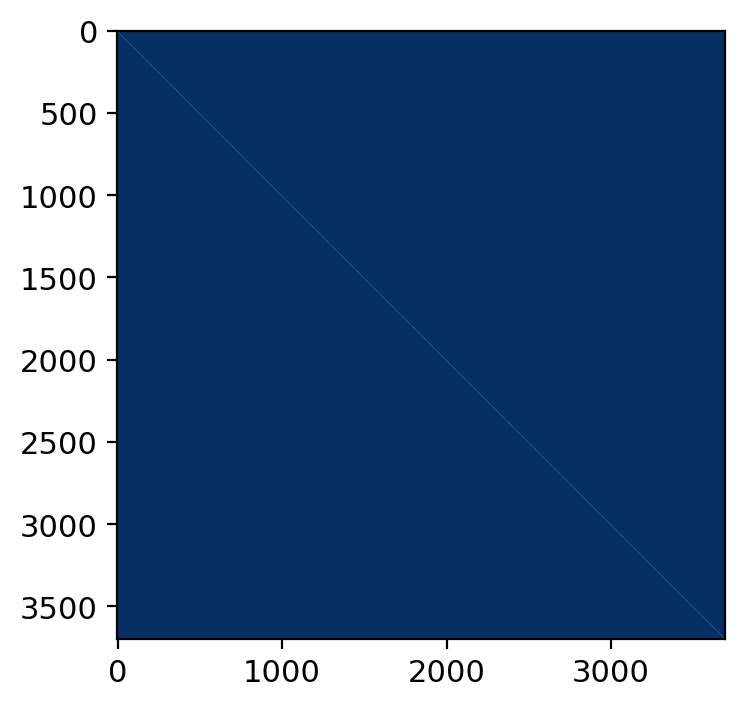

In [ ]:
plt.imshow(A)